# Basics of mobile robotics - EPFL

## Thymio Project - 12.12.2021

Iskandar Khemakhem, Erik Börve, Maximilian van Amerongen, Romane Belda

## Abstract

This report presents the choices we made to achive the project goal of navigating the differential drive robot, refered to as "Thymio", in an enviorment containing known and unknown obstacles. Furthermore, certain parts of the code will be highlighted to support the made design choices.

To achieve the goal, different image processing techniques have been applied to sense Thymio's enviornment and to build up a map. Different path planning techniques were applied to the map to come up with a path that navigates the robot from its start to its goal position.
A Kalman Fitler was designed to fuse different sensors and localize the Thymio on the map.

Finally, simple motion control combined with local obstacle avoidance has been applied to achieve path following and to avoid unknown obstacles.

## Introduction

December 2021, a group of 4 students has kipnapped one of the famous robots, called "Thymio". Thymio is having a hard time with the students, why he is trying to escape from them and to return back to its creator Mr. Thymio. However, it turns out that this is not easy task. During his journey, Thymio will face global obstacles, students will cross his path (local obstacles) and he will be kipnapped for a second time. The question is, in this difficult circumstances, will Thymio manage to reach his goal to be reunited with its creator agian?

We wish him all the best.

![Set Up](Report_Images/set_up.jpg)

In [6]:
Video("Video/ThymioProject_LowQual.mp4")

## Vision 

### Image processing for environment

First, taking the raw camera input and reading it as a grayscale image yields the following result.

![camera_input](Report_Images/input_img.png)

The grayscaled images are the preprocessed in 3 steps. To preserve the edges in the initial smoothing step, a bilateral filter was applied. After smoothing, it was possible to perform a threshholding operation which was tuned based on the current lighting conditions to maximize accuracy. Finnaly, a morphological opening filter was applied to remove any potential noise and smooth edges.

![Camera_input](Report_Images/preprocess_img.png)

To then identify the environment, the contours of the image are then calculated.
To ensure that the correct contour is found, the maximum distance between the extreme points of the contour is calculated. 
The correct contour then corresponds to contour with the largest calculated distance. This gives the following,

![contourz](Report_Images/contour_img.png)

Finally, to express the environment from an appropriate perspective, a 4-point transform is computed using the corners of the contour. 
The result is a cropped and rotated frame that can be used both initially for the global pathfinding and continuously to give appropriate measurements for the kalman filter.

![result](Report_Images/warp_img.png)

## Goal and start localization

To have a robust localization of the beautiful goal the scale invariant feature transform (SIFT) algorithm was used. Applying this to the template and input image gives a set of matching features points in each corresponding image. To get a single fixed goal position the mean position of the 10 best SIFT correspondance was calculated. Obtaining the initial position of the Thymio was done using the Aruco packages which is described further in the localization section. The final result is the following,

![result](Report_Images/result_img.png)

## Global navigation 

Having the map from the vision part in an array form, we start by down scaling the map to reduce the computation time. A maximum mask is used for this purpose, i.e., for a downscaling with a factor m in the $x$-direction and a facor n in the $y$-direction, every m $\times$ n-square of pixels will be reduced to one pixel. In case there is any part of the obstacle in the mask, the resulting pixel will take the value of an obstacle.  
The $x$- and $y$-coordinates of the obstacles in the scaled map are then extracted in a list and given to the path-planning.

resolution of the scaled map:  (100, 141)
robot radius: 9.0
grid size: 6.0
MAX_EDGE_LEN: 5.610068485175659


(-7.050000000000001, 148.05, -5.0, 105.0)

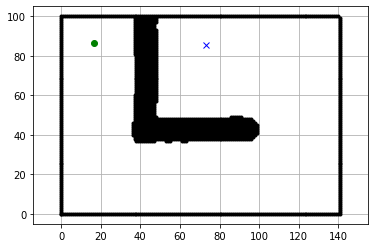

In [6]:
#create a function to plot resulting map

ox, oy, sx, sy, gx, gy, robot_radius, grid_size = get_map(globalMap, startPos, goalPos)
plt.plot(ox, oy, ".k")
plt.plot(sx, sy, "og")
plt.plot(gx, gy, "xb")
plt.grid(True)
plt.axis("equal")

Knowing the environment and the start and end positions, we start by planning the path for navigating the map. To find a collision-free path from the robot to the goal, the following three path planning algorithms are tested in order to find the most efficient one: 

- A*
- Probabilistic road map
- Voronoi road map

We use the Path planning library of Atsushi Sakai available on https://github.com/AtsushiSakai/PythonRobotics.

### A*

The A* algorithm is a grid based algorithm that is based on the Dijkstra algorithm. The algorithm is widely used due to its completeness, optimality and optimal efficiency. The algorithm finds the lowest cost path from the start position to the end position with the cost function $f(n)$, with

\begin{equation}
f(n) = h(n) + g(n)
\end{equation}

A* explores a tree using a best first search principle with a heuristic $h(n)$ that gives the manhatten distance to the goal. The function $g(n)$ represents the cost of the path from start position to the node $n$. Here the function $g(n)$ penalizes the motion across the diagonals from one grid to the next by giving it a cost of $\sqrt{2}$ compared to a cost of $1$ in the other cases. 
Note that for the differential drive robot a different cost function can be programmed to get a more feasible path. This is in our case unnecessary since the path will be smoothed afterwards.

min_x: 0
min_y: 0
max_x: 141
max_y: 100
x_width: 24
y_width: 17
Find goal


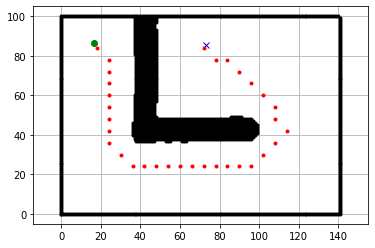

In [7]:
# A_star algorithm

a_star = AStarPlanner(ox, oy, grid_size, robot_radius)
rx, ry = a_star.planning(sx, sy, gx, gy)
rx.reverse()
ry.reverse()
plot_path(ox, oy, rx, ry, sx, sy, gx, gy)

### Probabilistic road map

The probabilistic road map is a smpling based node that selects random points on the free space of a map. The random points form the vertices of a graph and the edges are formed to connect the vertices in the free space taking into consideration a predefined maximum edge length and the maximum degree of the graph (maximum number of edges for each vertex). A graph based search (Dijkstra) is then applied to find the shortest path. 
This algorithm is probabilistically complete and yields for high number of samples the optimal path.

number of sample_points 1500
number of edges from one sampled point 500
Maximum edge length 4
goal is found!


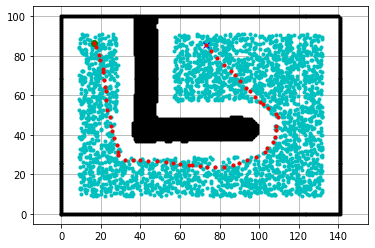

In [8]:
#probabilisitc road map
# parameter
N_SAMPLE = 1500  # number of sample_points
N_KNN = 500  # number of edges from one sampled point
MAX_EDGE_LEN = 4

rx, ry = prm.prm_planning(sx, sy, gx, gy, ox, oy, robot_radius, N_SAMPLE, N_KNN, MAX_EDGE_LEN)
rx.reverse()
ry.reverse()
plot_path(ox,oy,rx,ry, sx, sy, gx, gy)

### Voronoi Road Map

The Voronoi algorithm is based on generating a Voronoi partition of the map. A Voronoi partition of a map gives the set of pints that ar at equal distance from anz two closest obstacles. The shortest path is then computed on the voronoi diagramm. In short, the algorithm maximises the distance between the robot and the obstacles. While the resulting path is not optimal, it is the safest in order to avoid any collision with the obstacles.

goal is found!


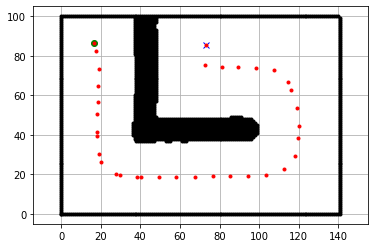

In [9]:
# Voronoi algorithm
N_KNN = 1500  # number of edges from one sampled point
MAX_EDGE_LEN = 10
voronoi = VoronoiRoadMapPlanner(N_KNN, MAX_EDGE_LEN)
rx, ry = voronoi.planning(sx, sy, gx, gy, ox, oy, robot_radius)

plot_path(ox,oy,rx,ry,sx,sy,gx,gy)

By comparing the different algorithms we decide to use the path generated by the Voronoi Raod Map algorithm. While A* is considerably faster than the two other algorthms, and probablisitic road map delivers a nearly optimal path, Voronoi gives the safest path as it maximizes the distance to the obstacles. A* and PRM algorithms try to find the shortest path to the goal which leads to going close to the obstacle making unwanted collisions more probable.

#### Smoothing the path

As we are using a non-holonomic robot, a smooth path is important. Added to that, the Voronoi algorithm only finds a path with a relatively low number of points. To solve these 2 problems, we interploate a function to the path points generated from the path planning algorithm using B-splines.  

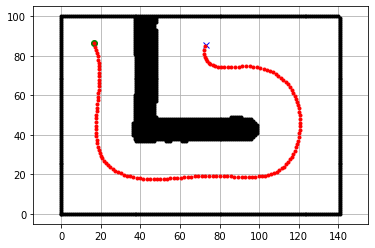

In [11]:
smooth_func, u = interpolate.splprep([rx, ry])
rxint, ryint = interpolate.splev(np.linspace(0, 1, 150), smooth_func)
plot_path(ox,oy,rxint,ryint, sx, sy, gx, gy)

## Filtering

## Filtering:

To control the robot and let it follow the desired path, it is recquired to locate the robot in its enviornment. 
Different sensors are available and they give information about the robots pose and the evolution of the pose.
To fuse the information that those sensors deliver, a filter technique is requried. 
Assuming that the noise on the sensors is Gaussian, Kalman Fitlering offers a simple solution to fuse different sensors. Therefore a Kalman Fitler has been implemented.

## Kalman Filter

Kalman Filtering estimates the state $x_k$ based on combining a predicted state with measurements $z_k$ that contain information of the state. The state vector $x_k$ at time step $k$ will be defined as $x_k = [px_k, py_k, \theta_k,v_k,\omega_k]^T$. Here $px_k$ and $py_k$ represent the x and y-position of the robot, while $\theta_k$ represents the robots orientation. The linear and angular velocity of the robot are denoted by $v_k$ and $\omega_k$. As mentioned before, Kalman Filtering combines measurements with state predictions. Therefore a motion and an observation model is required.

### Motion model
The motion model describes the evoultion of the state $x_{k+1}$ during one time step of duration $\Delta_t$, based on its acutal state $x_k$ and the given input $u_k$. Linear $v_k$ and angular $\omega_k$ velocities are choosen as an input to the model. The Thymio can be controlled by sending left and right wheels velocity commands to it. 
Those commands were translated to linear and angular velocities $v_k$ and $\omega_k$ to use them as an input to the motion model. Furthermore, the motion model of the Kalman Filter is based on the assumption, that after one taken control action $u_k$ the robot stops moving until a new control action is taken. Therefore the used motion model is given by:

\begin{equation}
x_{k+1} = Fx_k+Bu_k+w_k = 
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}
\cdot
\begin{bmatrix}
px_k \\
py_k \\
\theta_k \\ 
v_k \\
\omega_k \\
\end{bmatrix}
+
\begin{bmatrix}
\Delta_t \cdot cos(\theta_k) & 0 \\ 
\Delta_t \cdot sin(\theta_k) & 0 \\
0                            & \Delta_t \\
1                            & 0 \\
0                            & 1
\end{bmatrix}
\begin{bmatrix}
v_k \\
\omega_k
\end{bmatrix}
+ w_k
\end{equation}

The trigonometric functions contained in the motion model, make the motion model non-linear. Therefore, a nonlinear version of the Kalman Filter needs to be implemented. In the considered case, an Extended Kalman Filter (EKF) has been applied.

### Observation model

The observation model relates the measurements to the states. Since in the considered case all states are measured, the observation model becomes:

\begin{equation}
z_k = Hx_k + \nu_k = 
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1
\end{bmatrix}
\cdot
\begin{bmatrix}
px_k \\
py_k \\
\theta_k \\ 
v_k \\
\omega_k \\
\end{bmatrix}
+\nu_k
\end{equation}

## Sensors 
As mentioned before, Kalman Filtering allows to fuse measurements retrieved from different sensors. The robots pose, defined by $[px_k,py_k,\theta_k]^T$, is measured by the camera, whereas its velcoities $[v_k,\omega_k]$ are measured by the Thymio itself. To fuse the information, Kalman Filtering requires an educated guess about the covariances values of the measurement noise $w_k$ and the process noise $\nu_k$. The variance values of the measurement noise are stored on the diagonal of the measurement covaraince matrix $R$, whereas the varaince values of the process noise are stored on the diagonal of the process covariance matrix $Q$.
The $Q$ and $R$ matrix define how much the Kalman Filter "trusts" the measurements and its previously predicted state when estimating the current state. Changing their values, changes the behavior of the Kalman Filter. Therefore, the behavior of the Kalman Filter can be "tuned" by changing the different variance values of the covariance matrix $Q$ and $R$.

### Pose:
The camera is used to measure the robots pose in its enviroment. To do so, it is made use of the Aruco package. Aruco is part of OpenCV and allows pose measurement using computer vision. More information about its working can be found here:(https://docs.opencv.org/4.x/d5/dae/tutorial_aruco_detection.html). To get an idea about the accuracy of the measurements the following paper was retrived: https://ria.ua.pt/bitstream/10773/23890/1/artigo.pdf. Under comaprable setup conditions, an orientation measurment accuracy of approximatly $1.4\%$ was achieved by making use of Aruco markers. Assuming the same accuracy for x and y position measurements and translating it to the used scale, results in the following standard deviation values:

\begin{equation}
\sigma_x = 0.01764 m \quad \sigma_y = 0.008316m \quad  \sigma_{\theta}= 0.04398rad
\end{equation}
 
### Velocity: 
The velocity of the wheels are measured using the velocity measurements taken by the Thymio. Those measurements are translated to SI units. Afte that the translated right and left wheel velcoites $V_r$ and $V_l$ are used to calculate the linear $v$ and angular velocity $\omega$ according to:

\begin{equation}
     v = \frac{V_r + V_l}{2} \quad \omega = \frac{V_r-V_l}{L}
\end{equation}

$L$ represents the wheel base of the robot, which was measured to be equal to $L = 0.095m$. Note, the same relation was used to translate the velocity commands to linear $v$ and angular $\omega$ velocity for the motion model of the Kalman Filter.

To get an estimate of the velocity measurement noise, the Thymio was driven with a constant input for a distance of $1m$. Assuming constant velocity, the velocity of the thymio was measured and the standard deviation of the data was calculated. During this expirment, the standard deviation was calculated to be less than $1\frac{mm}{s}$. Since an empricial estiamted constant is used to translate the thymio velocity measurements to SI units, it is assumed that there is more uncertainty on the data. Therefore the velocity measurement noise variance was set to $\sigma_ v= 3\frac{mm}{s} = 0.003\frac{m}{s}$. Assuming an equal percentage of noise on the angular velocity results in a angular velocity measurement standard deviation of $\sigma_\omega = 0.047 \frac{rad}{s}$. 

### Covariance matrix :

In the previous steps, it was explained how the measurement noise standard deviations for each measurement where derived. Therefore, the measurement noise covariance matrix $R$ is set to be equal to:

\begin{equation}
R = 
\begin{bmatrix} 
\sigma_x^2 & 0 & 0 & 0 & 0 \\
0        & \sigma_y^2 & 0 & 0 & 0 \\
0        &        0 & \sigma_\theta^2 & 0 & 0 \\
0        &        0 & 0             & \sigma_v^2 & 0 \\
0        &        0 & 0             & 0        & \sigma_\omega^2
\end{bmatrix}
= 
\begin{bmatrix}
{0.01764}^2 m^2 & 0 & 0 & 0 & 0 \\
0        & 0.008316^2m^2 & 0 & 0 & 0 \\
0        &        0 & 0.04398^2rad^2 & 0 & 0 \\
0        &        0 & 0             & 0.003^2(\frac{m}{s})^2 & 0 \\
0        &        0 & 0             & 0        &  0.047^2 \frac{rad}{s}^2
\end{bmatrix}
\end{equation}

It is expected that during executing the code, the Kalman Filter receives unreliable/no pose measurment data of the camera (by holding the hand in front of the camera). This implies that for the pose, it is desired that the Kalman Filter "trusts" during state estimation more its motion model than the received measurements. This behavior can achieved by reducing the process noise variance values compared to the measurement noise variance values. Therefore, the process noise variance values for the pose are set to $0.2$ times the values of the measurement noise. In the case of the linear and angular velocity, it is not expected that during the expiriments the Kalman Filter stops receving measurements. Therefore the process noise variance values for linear and angular velocity are set to be equal to the measurement noise variance values. This initializes the process noise covariance matrix as:

\begin{equation}
Q = 
\begin{bmatrix} 
0.2\cdot\sigma_x^2 & 0 & 0 & 0 & 0 \\
0        & 0.2\cdot\sigma_y^2 & 0 & 0 & 0 \\
0        &        0 & 0.2\cdot\sigma_\theta^2 & 0 & 0 \\
0        &        0 & 0             & \sigma_v^2 & 0 \\
0        &        0 & 0             & 0        & \sigma_\omega^2
\end{bmatrix}
= 
\begin{bmatrix}
{0.003528}^2 m^2 & 0 & 0 & 0 & 0 \\
0        & 0.001663^2m^2 & 0 & 0 & 0 \\
0        &        0 & 0.00880^2rad^2 & 0 & 0 \\
0        &        0 & 0             & 0.003^2\frac{m}{s}^2 & 0 \\
0        &        0 & 0             & 0        &  0.047^2 (\frac{rad}{s})^2
\end{bmatrix}
\end{equation}

## Implementation

The main function calls a function called kalman_measure. This function takes and stores the actual pose and velocity measurments. After taking the measurements, the function EKF() is called. It is defined in the ekf.py file. Furthermore it calls the functions ekf_correct() and ekf_predict(). Those functions perform the correction and prediction steps of the Kalman Filter.

## Results:




In the video below the performance of the Kalman Filter was tested. It can be recognized that the Kalman Filter manages to estimate the pose of the robot also in the situation of kidnapping successfully.

In [12]:
Video("Video/thymioVid_kidnapp.avi")

## Motion control

#### First Alternative


We use a basic control motion algorithm. To move from one point to the following on the path, we first compute the angle difference between the robot orientation and the straight line connecting the two successive points on the path. The robot rotates in the right direction until the kalman-filter angle estimate matches the angle of the connecting line (with a small range of error). The robot drives then with a constant speed in a straight line to the next position and stops when the difference between kalman-position estimate and the nest position is within a certain range. The motion control algorithm runs with a $5Hz$ frequency. 

This method was used combined with local obstacle avoidance and is shown in the video.

#### 2. Alternative

To be able to control the robot, we first need a mathematical model. We llok at the one-cycle kinematic model that can deduced bz applying the trigonometric rules. The robot pose can be described in a 2-dimensional problem using 3 minimal-coordinates ($x$, $y$ and $\theta$). The robot takes as input the translational velocity $v$ and angular velocity $\omega$. The continous-time kinematic model of the robot is as following: 
$$
\dot {\textbf{x}} = \begin{bmatrix}
x(t))\\
y(t)\\
\theta(t)
\end{bmatrix}
=
\begin{bmatrix}
v(t)cos(\theta(t))\\
v(t)sin(\theta(t))\\
\omega(t)
\end{bmatrix}
$$

In the case of a zero-order hold (input stays constant over the time-step). The details about the discretation process are ommited for brievety. As a result we get the exact discrete-time model. The discrete-time model is then inverted to compute an input $\textbf{u}_k = [v_k, \omega_k]$ from a start position $\textbf{x}_k = [x_k, y_k, \theta_k]$ and a goal position $\textbf{x}_{k+1} = [x_{k+1}, y_{k+1}, \theta_{k+1}]$.
It is necessay to consider the liits on the input of the robot and the constraints acting on the robots kinematics. As a result it is important to have a smooth path with a big number of points and a relativelz large time step. 



##### Factor estimation
First step in the motion control is to determine the transform the thymio wheel speeds to SI units. Motion control works with linear and angular velocities, whereas the thymio takes unitless wheel velocities. To find the relationship between linear velocity and thymio wheel velocity we measure the time needed by the robot to travel 1 meter using different velocities. We use for this purpose the Aseba code provided by Ben Ari (for details see http://smart-machines.hs-kl.de/wp-content/uploads/2018/09/thymio-programming-exercises-en.pdf). 

Having the measurments, we fit a linear model:

In [15]:
X = np.array([[100], [200], [300]])#, [400], [500]])
y = np.array([[0.03], [0.0578], [0.0847]])#, [0.1126], [0.1316]])
reg = LinearRegression().fit(X, y)
factor = float(reg.coef_)
print('factor from thymio motor speed to linear velocity: ', factor)

factor from thymio motor speed to linear velocity:  0.0002735


In the following video we run the method in an open-loop. here the pose of the robot is not measured and there is no feedback for correcting the error. The results shows that the robot was able to reach the goal.
If we had more time, we would like to work on closing the loop and stabilizing the path following. The method is however still promising in staying on the path when the pose estiamation not available anymore. We couldn't implement this part either in the project due to lack of time.

In [13]:


Video("Video/thymioVid_open1.avi")


## Local navigation 

### Local obstacle avoidance 

During the global navigation, the Thymio is following the global trajectory. Unfortunately, some unforseen obstacle can appear. The robot should be able to avoid them and still follow its path. For this purpose a local obstacle avoidance should be implemented.

To avoid local obstacles, during each iteration of the path planning, the proximity sensors are analyzed. 
When they exceed a certain limit it means that the obstacle is close. Then starts local obstacle avoidance.
Otherwise, it continues to follow the defined path.

The obstacle avoidance strategie used here is following the obstacle on the left side and leaving the obstacle as soon as the robot is close enoght to some coordinate of the path.

As long as the object is close, the robot will turn to the left. Once the object is no longer in the field of view, the robot will slowly move forward and then turn to the right to test if the obstacle is still there or not. These steps will be repeated as long as the Thymio has not reached its initial path, this is test with the function *path_found*.

The function *path_found* is linked to the position of the robot determined by the kalman filter and the path coordinates given by the Voroni filter. 

# Conclusion

Finally, techniques of image processing, path planning, filtering, motion control and local obstacle avoidance have been combined. 

Till to the last moment, it was thrilling whether Thymio would be able to reach its goal. Luckily he did!

For further reasearch we recomand to improve the motion control by making use of inverse kinematics. Open loop tests showed promesing results.

It was a fun project, we learned a lot, and thats where we would like to thank you for.

Finally, we as a group would also like to thank Romane for hosting us for an entire week almost 24/7. 

See you at the presentation!

Best,

Iskandar, Erik, Romane and Max